## Dependencies

In [1]:
import os
import cv2
import shutil
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras import backend as K
from keras.models import Model
from keras.utils import to_categorical
from keras import optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback, LearningRateScheduler
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input

# Set seeds to make the experiment more reproducible.
from tensorflow import set_random_seed
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    set_random_seed(0)
seed = 0
seed_everything(seed)

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

Using TensorFlow backend.


## Load data

In [2]:
hold_out_set = pd.read_csv('../input/aptos-data-split/hold-out.csv')
X_train = hold_out_set[hold_out_set['set'] == 'train']
X_val = hold_out_set[hold_out_set['set'] == 'validation']
test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
print('Number of train samples: ', X_train.shape[0])
print('Number of validation samples: ', X_val.shape[0])
print('Number of test samples: ', test.shape[0])

# Preprocecss data
X_train["id_code"] = X_train["id_code"].apply(lambda x: x + ".png")
X_val["id_code"] = X_val["id_code"].apply(lambda x: x + ".png")
test["id_code"] = test["id_code"].apply(lambda x: x + ".png")
X_train['diagnosis'] = X_train['diagnosis']
X_val['diagnosis'] = X_val['diagnosis']
display(X_train.head())

Number of train samples:  2929
Number of validation samples:  733
Number of test samples:  1928


,id_code,diagnosis,height,width,set
0,55eac26bd383.png,1,1736,2416,train
1,44e0d56e9d42.png,2,2136,3216,train
2,aa4407aab872.png,0,1050,1050,train
3,cffc50047828.png,0,614,819,train
4,b0f0fa677d5f.png,0,1050,1050,train


# Model parameters

In [3]:
# Model parameters
BATCH_SIZE = 8
EPOCHS = 40
WARMUP_EPOCHS = 5
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 224
WIDTH = 224
CHANNELS = 3
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

# Pre-procecess images

In [4]:
train_base_path = '../input/aptos2019-blindness-detection/train_images/'
test_base_path = '../input/aptos2019-blindness-detection/test_images/'
train_dest_path = 'base_dir/train_images/'
validation_dest_path = 'base_dir/validation_images/'
test_dest_path =  'base_dir/test_images/'

# Making sure directories don't exist
if os.path.exists(train_dest_path):
    shutil.rmtree(train_dest_path)
if os.path.exists(validation_dest_path):
    shutil.rmtree(validation_dest_path)
if os.path.exists(test_dest_path):
    shutil.rmtree(test_dest_path)
    
# Creating train, validation and test directories
os.makedirs(train_dest_path)
os.makedirs(validation_dest_path)
os.makedirs(test_dest_path)

def crop_image(img, tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img
    
def circle_crop(img):   
    img = crop_image(img)    
    
    height, width, depth = img.shape
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image(img)
    
    return img 
    
def preprocess_image(base_path, save_path, image_id, HEIGHT, WIDTH, sigmaX=10):
    image = cv2.imread(base_path + image_id)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = circle_crop(image)
    image = cv2.resize(image, (HEIGHT, WIDTH))
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0,0), sigmaX), -4 , 128)
    cv2.imwrite(save_path + image_id, image)
    
# Pre-procecss train set
for i, image_id in enumerate(X_train['id_code']):
    preprocess_image(train_base_path, train_dest_path, image_id, HEIGHT, WIDTH)
    
# Pre-procecss validation set
for i, image_id in enumerate(X_val['id_code']):
    preprocess_image(train_base_path, validation_dest_path, image_id, HEIGHT, WIDTH)
    
# Pre-procecss test set
for i, image_id in enumerate(test['id_code']):
    preprocess_image(test_base_path, test_dest_path, image_id, HEIGHT, WIDTH)

# Data generator

In [5]:
train_datagen=ImageDataGenerator(rescale=1./255, 
                                 rotation_range=360,
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 fill_mode='constant',
                                 cval=0.)

validation_datagen=ImageDataGenerator(rescale=1./255, 
                                      rotation_range=360,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='constant',
                                      cval=0.)

test_datagen=ImageDataGenerator(rescale=1./255, 
                                rotation_range=360,
                                horizontal_flip=True,
                                vertical_flip=True,
                                fill_mode='constant',
                                cval=0.)

train_generator=train_datagen.flow_from_dataframe(
                              dataframe=X_train,
                              directory=train_dest_path,
                              x_col="id_code",
                              y_col="diagnosis",
                              class_mode="raw",
                              batch_size=BATCH_SIZE,
                              target_size=(HEIGHT, WIDTH),
                              seed=seed)

valid_generator=validation_datagen.flow_from_dataframe(
                                        dataframe=X_val,
                                        directory=validation_dest_path,
                                        x_col="id_code",
                                        y_col="diagnosis",
                                        class_mode="raw",
                                        batch_size=BATCH_SIZE,
                                        target_size=(HEIGHT, WIDTH),
                                        seed=seed)

test_generator = test_datagen.flow_from_dataframe(  
                              dataframe=test,
                              directory=test_dest_path,
                              x_col="id_code",
                              batch_size=1,
                              class_mode=None,
                              shuffle=False,
                              target_size=(HEIGHT, WIDTH),
                              seed=seed)

Found 2929 validated image filenames.
Found 733 validated image filenames.
Found 1928 validated image filenames.


# Model

In [6]:
def create_model(input_shape):
    input_tensor = Input(shape=input_shape)
    base_model = applications.ResNet50(weights=None, 
                                       include_top=False,
                                       input_tensor=input_tensor)
    base_model.load_weights('../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(1, activation='linear', name='final_output')(x)
    model = Model(input_tensor, final_output)
    
    return model

# Train top layers

In [7]:
model = create_model(input_shape=(HEIGHT, WIDTH, CHANNELS))

for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True
    
metric_list = ["accuracy"]
optimizer = optimizers.Adam(lr=WARMUP_LEARNING_RATE)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=metric_list)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [8]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

history_warmup = model.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,
                                     validation_steps=STEP_SIZE_VALID,
                                     epochs=WARMUP_EPOCHS,
                                     verbose=1).history

Epoch 1/5
366/366 [==============================] - 45s 123ms/step - loss: 2.2550 - acc: 0.3186 - val_loss: 1.8582 - val_acc: 0.0975
Epoch 2/5
366/366 [==============================] - 41s 112ms/step - loss: 0.9660 - acc: 0.4546 - val_loss: 2.1017 - val_acc: 0.0952
Epoch 3/5
366/366 [==============================] - 40s 110ms/step - loss: 0.8797 - acc: 0.4990 - val_loss: 1.9874 - val_acc: 0.0993
Epoch 4/5
366/366 [==============================] - 40s 110ms/step - loss: 0.9186 - acc: 0.4993 - val_loss: 1.9685 - val_acc: 0.0979
Epoch 5/5
366/366 [==============================] - 40s 109ms/step - loss: 0.8695 - acc: 0.5038 - val_loss: 2.1440 - val_acc: 0.1697


# Fine-tune the complete model (1st step)

In [9]:
for layer in model.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=metric_list)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [10]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=int(EPOCHS*0.8),
                                          callbacks=callback_list,
                                          verbose=1).history

Epoch 1/32
366/366 [==============================] - 66s 180ms/step - loss: 0.7281 - acc: 0.5919 - val_loss: 0.5511 - val_acc: 0.7214
Epoch 2/32
366/366 [==============================] - 52s 141ms/step - loss: 0.5311 - acc: 0.6605 - val_loss: 0.4853 - val_acc: 0.7352
Epoch 3/32
366/366 [==============================] - 53s 145ms/step - loss: 0.4665 - acc: 0.6964 - val_loss: 0.4205 - val_acc: 0.7655
Epoch 4/32
366/366 [==============================] - 52s 143ms/step - loss: 0.4596 - acc: 0.7042 - val_loss: 0.4477 - val_acc: 0.7241
Epoch 5/32
366/366 [==============================] - 52s 143ms/step - loss: 0.4320 - acc: 0.7083 - val_loss: 0.4074 - val_acc: 0.7503
Epoch 6/32
366/366 [==============================] - 52s 143ms/step - loss: 0.3997 - acc: 0.7100 - val_loss: 0.4418 - val_acc: 0.7324
Epoch 7/32
366/366 [==============================] - 53s 144ms/step - loss: 0.3876 - acc: 0.7145 - val_loss: 0.4216 - val_acc: 0.7545
Epoch 8/32
366/366 [==============================] - 5

# Fine-tune the complete model (2nd step)

In [11]:
optimizer = optimizers.SGD(lr=LEARNING_RATE, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=metric_list)

In [12]:
history_finetunning_2 = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=int(EPOCHS*0.2),
                                          callbacks=callback_list,
                                          verbose=1).history

Epoch 1/8
366/366 [==============================] - 62s 168ms/step - loss: 0.2655 - acc: 0.7766 - val_loss: 0.4040 - val_acc: 0.7793
Epoch 2/8
366/366 [==============================] - 51s 140ms/step - loss: 0.2744 - acc: 0.7739 - val_loss: 0.4218 - val_acc: 0.7779
Epoch 3/8
366/366 [==============================] - 51s 140ms/step - loss: 0.2562 - acc: 0.7794 - val_loss: 0.4480 - val_acc: 0.7310
Epoch 4/8
366/366 [==============================] - 52s 141ms/step - loss: 0.2576 - acc: 0.7910 - val_loss: 0.4171 - val_acc: 0.7876

Epoch 00004: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 5/8
366/366 [==============================] - 51s 140ms/step - loss: 0.2436 - acc: 0.7896 - val_loss: 0.3606 - val_acc: 0.7848
Epoch 6/8
366/366 [==============================] - 52s 141ms/step - loss: 0.2439 - acc: 0.7944 - val_loss: 0.4207 - val_acc: 0.7959
Epoch 7/8
366/366 [==============================] - 51s 140ms/step - loss: 0.2567 - acc: 0.7818 - val_loss: 0.4420

# Model loss graph 

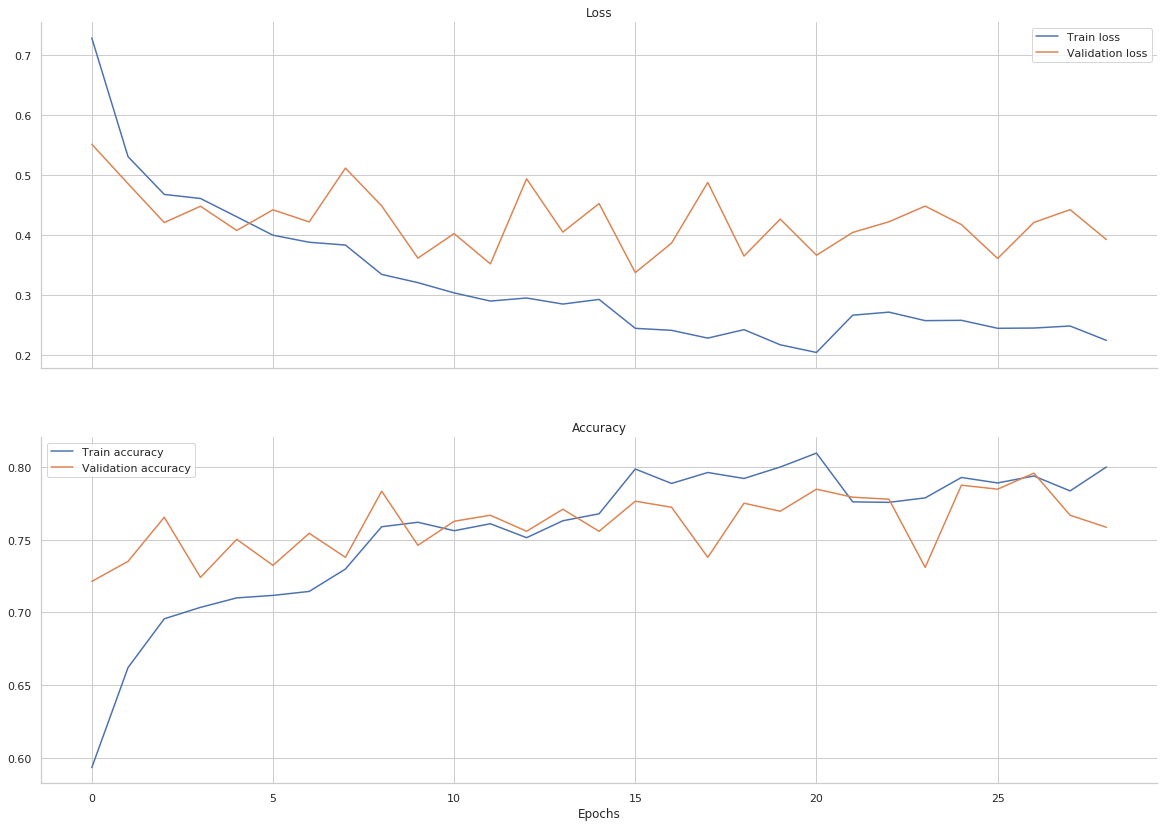

In [13]:
history = {'loss': history_finetunning['loss'] + history_finetunning_2['loss'], 
           'val_loss': history_finetunning['val_loss'] + history_finetunning_2['val_loss'], 
           'acc': history_finetunning['acc'] + history_finetunning_2['acc'], 
           'val_acc': history_finetunning['val_acc'] + history_finetunning_2['val_acc']}

sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['acc'], label='Train accuracy')
ax2.plot(history['val_acc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [14]:
# Create empty arays to keep the predictions and labels
df_preds = pd.DataFrame(columns=['label', 'pred', 'set'])
train_generator.reset()
valid_generator.reset()

# Add train predictions and labels
for i in range(STEP_SIZE_TRAIN + 1):
    im, lbl = next(train_generator)
    preds = model.predict(im, batch_size=train_generator.batch_size)
    for index in range(len(preds)):
        df_preds.loc[len(df_preds)] = [lbl[index], preds[index][0], 'train']

# Add validation predictions and labels
for i in range(STEP_SIZE_VALID + 1):
    im, lbl = next(valid_generator)
    preds = model.predict(im, batch_size=valid_generator.batch_size)
    for index in range(len(preds)):
        df_preds.loc[len(df_preds)] = [lbl[index], preds[index][0], 'validation']

df_preds['label'] = df_preds['label'].astype('int')

# Threshold optimization

Label 3: thr=0.52, Kappa=0.742


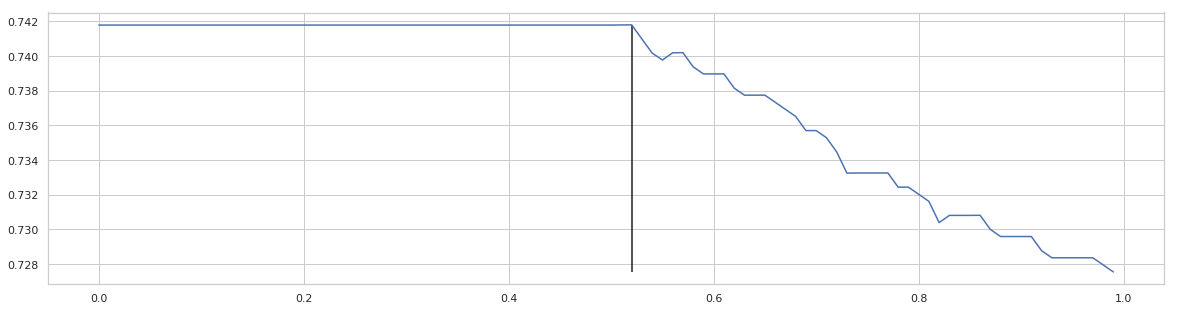

Label 2: thr=0.91, Kappa=0.770


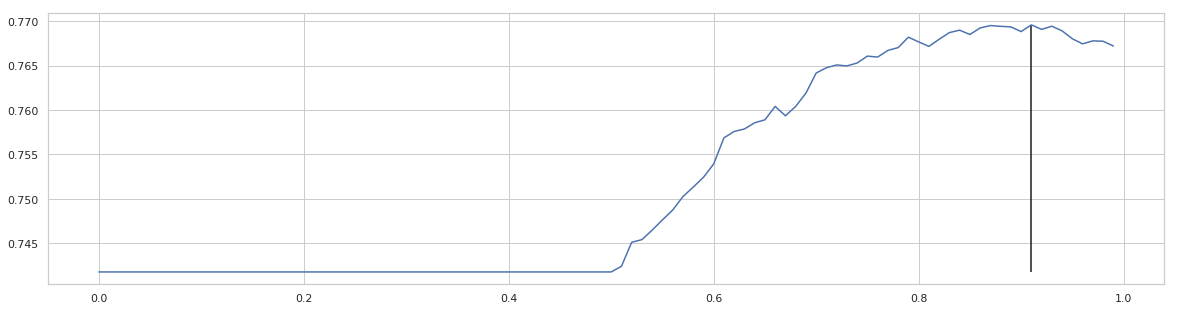

Label 1: thr=0.00, Kappa=0.742


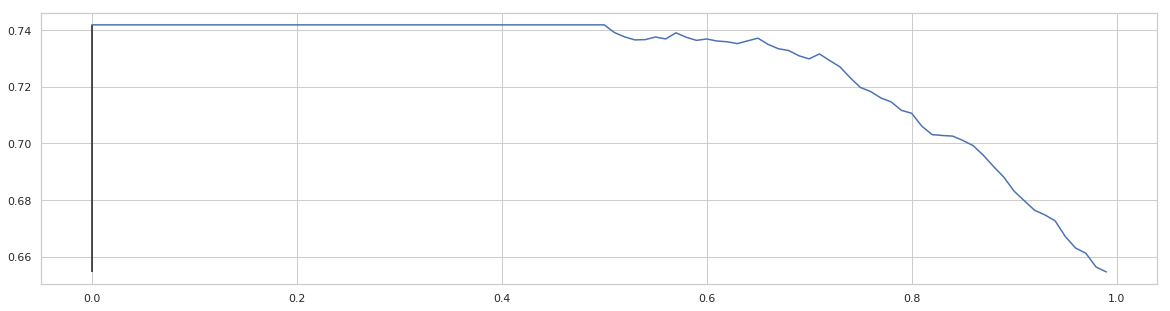

Label 0: thr=0.53, Kappa=0.742


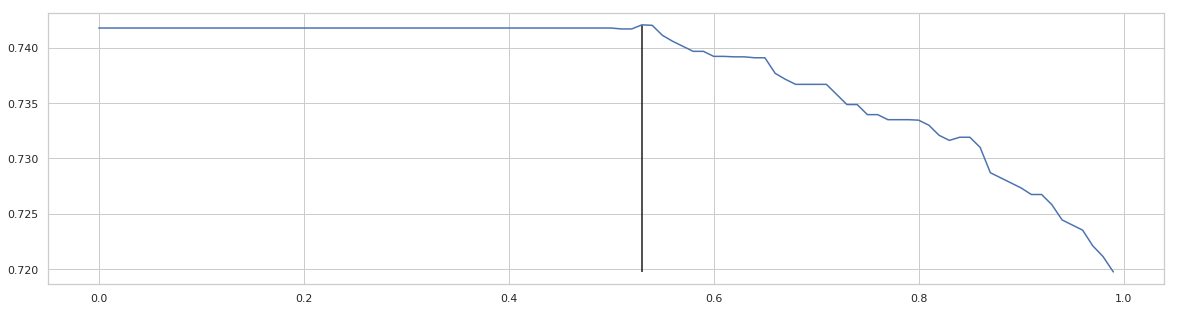

In [15]:
def classify(x):
    if x < 0.5:
        return 0
    elif x < 1.5:
        return 1
    elif x < 2.5:
        return 2
    elif x < 3.5:
        return 3
    return 4

def classify_opt(x):
    if x <= (0 + best_thr_0):
        return 0
    elif x <= (1 + best_thr_1):
        return 1
    elif x <= (2 + best_thr_2):
        return 2
    elif x <= (3 + best_thr_3):
        return 3
    return 4


def find_best_threshold(df, label, label_col='label', pred_col='pred', do_plot=True):
    score = []
    thrs = np.arange(0, 1, 0.01)
    for thr in thrs:
        preds_thr = [label if ((pred >= label and pred < label+1) and (pred < (label+thr))) else classify(pred) for pred in df[pred_col]]
        score.append(cohen_kappa_score(df[label_col].astype('int'), preds_thr))

    score = np.array(score)
    pm = score.argmax()
    best_thr, best_score = thrs[pm], score[pm].item()
    print('Label %s: thr=%.2f, Kappa=%.3f' % (label, best_thr, best_score))
    plt.rcParams["figure.figsize"] = (20, 5)
    plt.plot(thrs, score)
    plt.vlines(x=best_thr, ymin=score.min(), ymax=score.max())
    plt.show()
    
    return best_thr

# Best threshold for label 3
best_thr_3 = find_best_threshold(df_preds, 3)

# Best threshold for label 2
best_thr_2 = find_best_threshold(df_preds, 2)

# Best threshold for label 1
best_thr_1 = find_best_threshold(df_preds, 1)

# Best threshold for label 0
best_thr_0 = find_best_threshold(df_preds, 0)

In [16]:
# Classify predictions
df_preds['predictions'] = df_preds['pred'].apply(lambda x: classify(x))
# Apply optimized thresholds to the predictions
df_preds['predictions_opt'] = df_preds['pred'].apply(lambda x: classify_opt(x))

train_preds = df_preds[df_preds['set'] == 'train']
validation_preds = df_preds[df_preds['set'] == 'validation']

# Model Evaluation

## Confusion Matrix

### Original thresholds

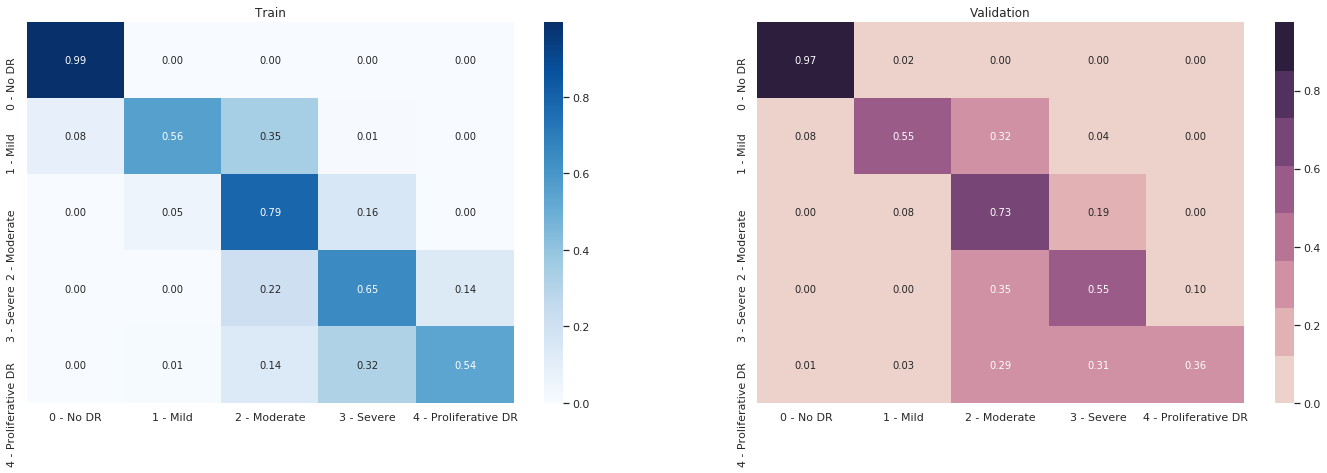

In [17]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
def plot_confusion_matrix(train, validation, labels=labels):
    train_labels, train_preds = train
    validation_labels, validation_preds = validation
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(24, 7))
    train_cnf_matrix = confusion_matrix(train_labels, train_preds)
    validation_cnf_matrix = confusion_matrix(validation_labels, validation_preds)

    train_cnf_matrix_norm = train_cnf_matrix.astype('float') / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
    validation_cnf_matrix_norm = validation_cnf_matrix.astype('float') / validation_cnf_matrix.sum(axis=1)[:, np.newaxis]

    train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=labels, columns=labels)
    validation_df_cm = pd.DataFrame(validation_cnf_matrix_norm, index=labels, columns=labels)

    sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Blues",ax=ax1).set_title('Train')
    sns.heatmap(validation_df_cm, annot=True, fmt='.2f', cmap=sns.cubehelix_palette(8),ax=ax2).set_title('Validation')
    plt.show()

plot_confusion_matrix((train_preds['label'], train_preds['predictions']), (validation_preds['label'], validation_preds['predictions']))

### Optimized thresholds

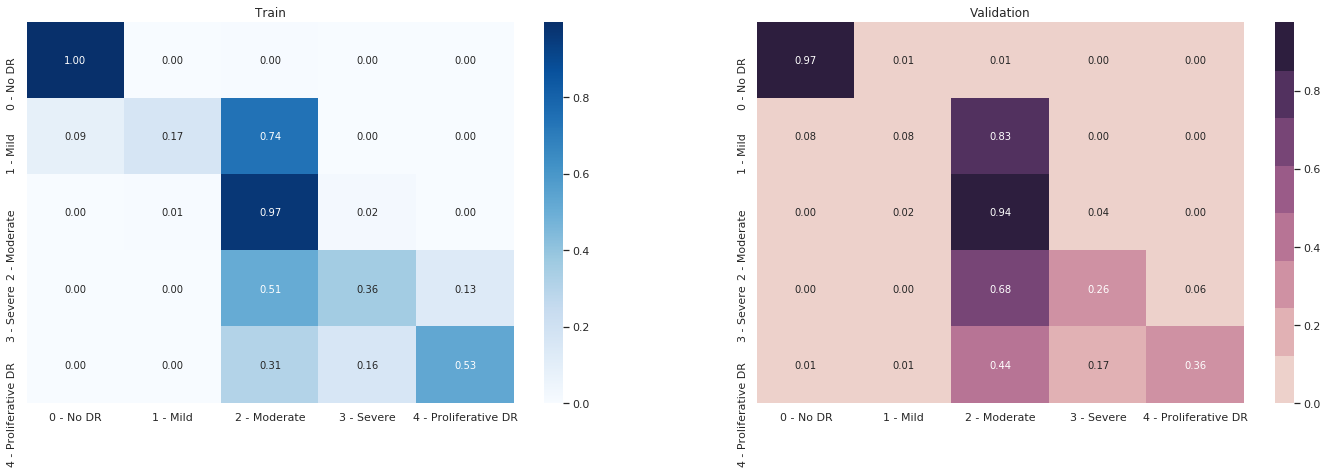

In [18]:
plot_confusion_matrix((train_preds['label'], train_preds['predictions_opt']), (validation_preds['label'], validation_preds['predictions_opt']))

## Quadratic Weighted Kappa

In [19]:
def evaluate_model(train, validation):
    train_labels, train_preds = train
    validation_labels, validation_preds = validation
    print("Train        Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, train_labels, weights='quadratic'))
    print("Validation   Cohen Kappa score: %.3f" % cohen_kappa_score(validation_preds, validation_labels, weights='quadratic'))
    print("Complete set Cohen Kappa score: %.3f" % cohen_kappa_score(np.append(train_preds, validation_preds), np.append(train_labels, validation_labels), weights='quadratic'))
    
print("   Original thresholds")
evaluate_model((train_preds['label'], train_preds['predictions']), (validation_preds['label'], validation_preds['predictions']))
print("   Optimized thresholds")
evaluate_model((train_preds['label'], train_preds['predictions_opt']), (validation_preds['label'], validation_preds['predictions_opt']))

   Original thresholds
Train        Cohen Kappa score: 0.937
Validation   Cohen Kappa score: 0.891
Complete set Cohen Kappa score: 0.928
   Optimized thresholds
Train        Cohen Kappa score: 0.920
Validation   Cohen Kappa score: 0.876
Complete set Cohen Kappa score: 0.911


## Apply model to test set and output predictions

In [20]:
def apply_tta(model, generator, steps=10):
    step_size = generator.n//generator.batch_size
    preds_tta = []
    for i in range(steps):
        generator.reset()
        preds = model.predict_generator(generator, steps=step_size)
        preds_tta.append(preds)

    return np.mean(preds_tta, axis=0)

preds = apply_tta(model, test_generator)
predictions = [classify(x) for x in preds]
predictions_opt = [classify_opt(x) for x in preds]

results = pd.DataFrame({'id_code':test['id_code'], 'diagnosis':predictions})
results['id_code'] = results['id_code'].map(lambda x: str(x)[:-4])

results_opt = pd.DataFrame({'id_code':test['id_code'], 'diagnosis':predictions_opt})
results_opt['id_code'] = results_opt['id_code'].map(lambda x: str(x)[:-4])

In [21]:
# Cleaning created directories
if os.path.exists(train_dest_path):
    shutil.rmtree(train_dest_path)
if os.path.exists(validation_dest_path):
    shutil.rmtree(validation_dest_path)
if os.path.exists(test_dest_path):
    shutil.rmtree(test_dest_path)

# Predictions class distribution

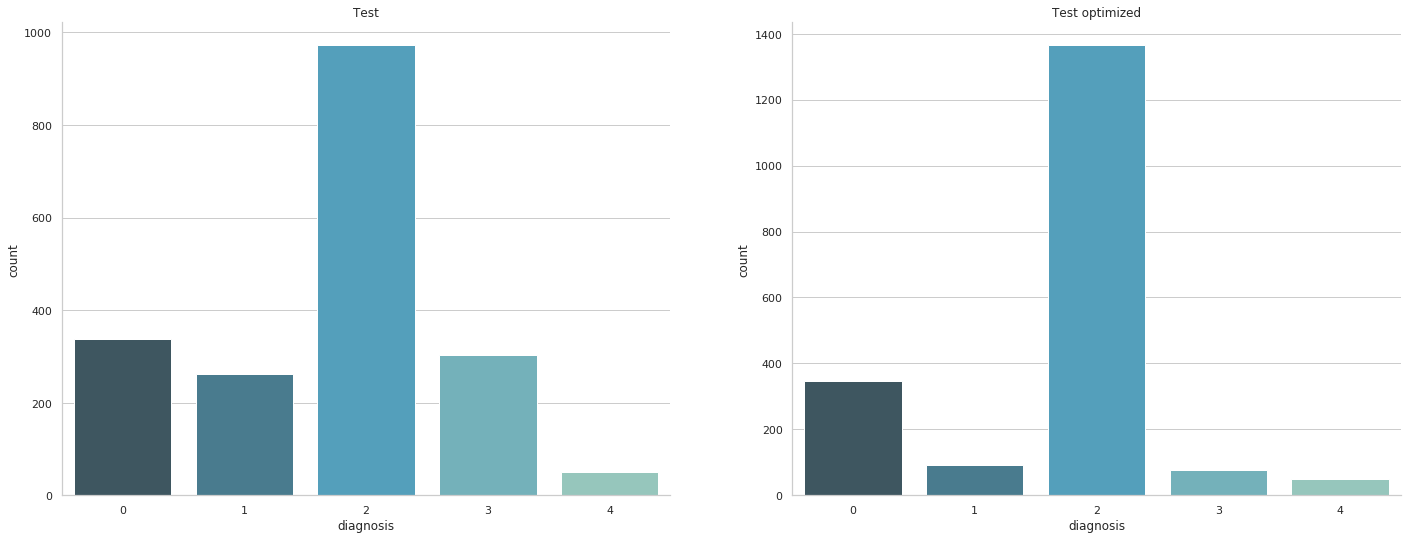

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(24, 8.7))
sns.countplot(x="diagnosis", data=results, palette="GnBu_d", ax=ax1).set_title('Test')
sns.countplot(x="diagnosis", data=results_opt, palette="GnBu_d", ax=ax2).set_title('Test optimized')
sns.despine()
plt.show()

In [23]:
val_kappa =  cohen_kappa_score(validation_preds['label'], validation_preds['predictions'], weights='quadratic')
val_opt_kappa = cohen_kappa_score(validation_preds['label'], validation_preds['predictions_opt'], weights='quadratic')

if val_kappa > val_opt_kappa:
    results_name = 'submission.csv'
    results_opt_name = 'submission_opt.csv'
else:
    results_name = 'submission_norm.csv'
    results_opt_name = 'submission_opt.csv'

In [24]:
results.to_csv(results_name, index=False)
display(results.head())

results_opt.to_csv(results_opt_name, index=False)
display(results_opt.head())

,id_code,diagnosis
0,0005cfc8afb6,1
1,003f0afdcd15,3
2,006efc72b638,3
3,00836aaacf06,2
4,009245722fa4,2


,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,2
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,2
